In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [4]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [5]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [6]:
target_house = '연립다세대'
house_df = data_prep(target_house, '매매')
print(house_df.shape)
house_df.head()

16it [00:01, 10.64it/s]


(631520, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0


In [7]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [8]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [9]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)

In [10]:
print(house_merge_df.shape)

(628988, 20)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '양천구'
target_dong = '신월동'
target_purpose = '3종일반'
target_building_age = 5
target_period = 18 # in months

In [13]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(553, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
207116,서울특별시 양천구 신월동 421-1,남부순환로67길 16,웨인빌,38.89,23.41,27200,4,2020.0,-1.0,2019-12-01,699.408588,1.0,대,634.2,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,소로각지,양천구,신월동
207117,서울특별시 양천구 신월동 421-1,남부순환로67길 16,웨인빌,37.87,22.65,27200,2,2020.0,0.0,2020-05-20,718.246633,1.0,대,634.2,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,소로각지,양천구,신월동
207118,서울특별시 양천구 신월동 421-1,남부순환로67길 16,웨인빌,38.89,23.41,27200,3,2020.0,0.0,2020-06-01,699.408588,1.0,대,634.2,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,소로각지,양천구,신월동
207119,서울특별시 양천구 신월동 421-1,남부순환로67길 16,웨인빌,37.87,22.65,27200,3,2020.0,0.0,2020-06-15,718.246633,1.0,대,634.2,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,소로각지,양천구,신월동
207120,서울특별시 양천구 신월동 421-1,남부순환로67길 16,웨인빌,36.81,22.39,26900,5,2020.0,0.0,2020-06-15,730.779679,1.0,대,634.2,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,소로각지,양천구,신월동


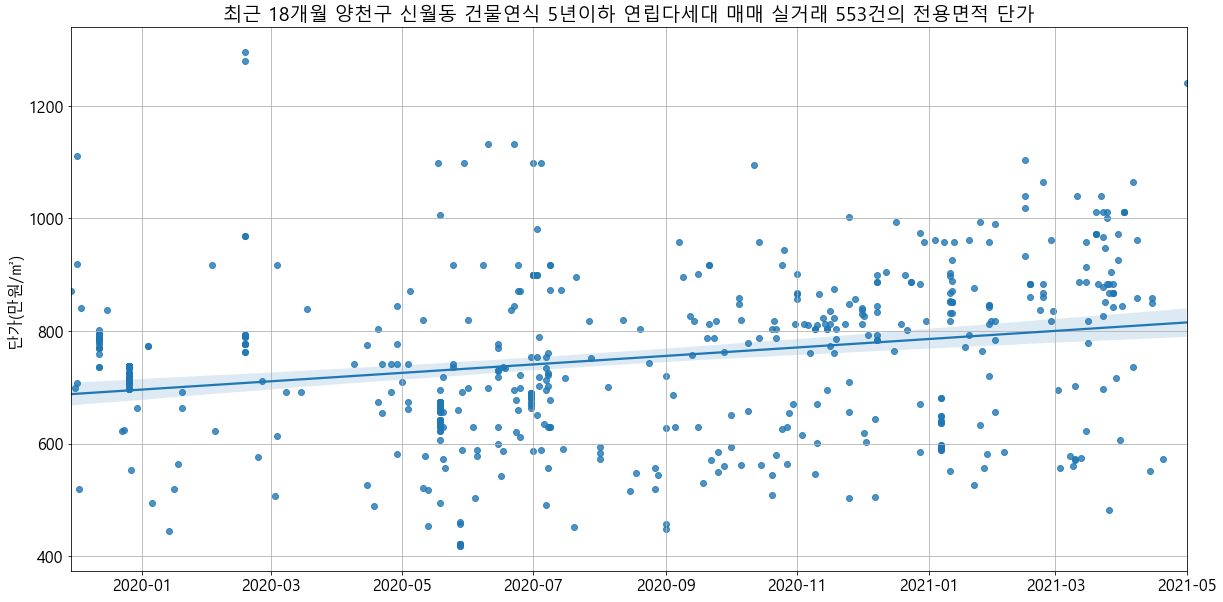

In [15]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전체_산포도.png'.format(target_gu, target_dong, target_house))

In [16]:
concat_df = pd.concat([target_df]).sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)

In [18]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']

In [19]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(553, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,단가평균
0,서울특별시 양천구 신월동 100-22,곰달래로7길 58,테마100,26.13,15.93,23400,2,2020.0,0.0,2020-07-21,895.522388,1.0,대,122.0,제2종일반주거지역,지정되지않음,단독,평지,정방형,세로한면(가),양천구,신월동,849.847331
1,서울특별시 양천구 신월동 100-22,곰달래로7길 58,테마100,29.72,18.11,23900,4,2020.0,0.0,2020-10-20,804.172275,1.0,대,122.0,제2종일반주거지역,지정되지않음,단독,평지,정방형,세로한면(가),양천구,신월동,849.847331
2,서울특별시 양천구 신월동 103-5,월정로33길 9-6,보노하우스,29.86,21.53,24000,6,2020.0,0.0,2020-04-20,803.750837,1.0,대,132.9,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(불),양천구,신월동,786.636960
3,서울특별시 양천구 신월동 103-5,월정로33길 9-6,보노하우스,29.86,21.53,24000,4,2020.0,0.0,2020-08-20,803.750837,1.0,대,132.9,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(불),양천구,신월동,786.636960
4,서울특별시 양천구 신월동 103-5,월정로33길 9-6,보노하우스,29.86,21.53,23500,3,2020.0,0.0,2020-09-20,787.006028,1.0,대,132.9,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(불),양천구,신월동,786.636960


In [20]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(88, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,단가평균
1,서울특별시 양천구 신월동 100-22,곰달래로7길 58,테마100,29.72,18.11,23900,4,2020.0,0.0,2020-10-20,804.172275,1.0,대,122.0,제2종일반주거지역,지정되지않음,단독,평지,정방형,세로한면(가),양천구,신월동,849.847331
14,서울특별시 양천구 신월동 103-5,월정로33길 9-6,보노하우스,29.89,21.54,24000,3,2020.0,0.0,2020-11-19,802.944128,1.0,대,132.9,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(불),양천구,신월동,786.636960
30,서울특별시 양천구 신월동 104-19,월정로 183-1,씨티하우스,29.95,23.99,29000,5,2019.0,1.0,2020-02-18,968.280467,2.0,대,379.0,제2종일반주거지역,지정되지않음,다세대,평지,자루형,중로한면,양천구,신월동,868.171833
34,서울특별시 양천구 신월동 1072-0,지양로 120,아레테시티,49.80,32.60,24000,5,2016.0,5.0,2021-03-26,481.927711,5.0,대,1958.8,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,중로한면,양천구,신월동,522.088353
42,서울특별시 양천구 신월동 108-12,곰달래로9길 41,코지빌,27.98,19.59,24000,2,2020.0,1.0,2021-04-15,857.755540,1.0,대,135.9,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로각지(가),양천구,신월동,841.275646
43,서울특별시 양천구 신월동 111-1,곰달래로7길 36,다인홈타운,53.09,31.06,29700,3,2017.0,4.0,2021-03-09,559.427387,4.0,대,639.8,제2종일반주거지역,지정되지않음,주상용,평지,정방형,소로각지,양천구,신월동,559.427387
58,서울특별시 양천구 신월동 112-10,곰달래로11길 35,예담뜰,27.66,17.70,19000,4,2019.0,1.0,2020-06-30,686.912509,2.0,대,259.0,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),양천구,신월동,686.506886
60,서울특별시 양천구 신월동 112-24,곰달래로9길 28,삼성쉐르빌,43.89,27.53,22200,3,2017.0,3.0,2020-12-07,505.809979,4.0,대,126.7,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),양천구,신월동,477.326785
89,서울특별시 양천구 신월동 126-36,곰달래로 15,삼화에코빌,48.87,30.13,32050,2,2020.0,0.0,2020-05-19,655.821567,1.0,대,903.7,제2종일반주거지역,지정되지않음,상업기타,평지,가로장방,중로각지,양천구,신월동,648.832911
91,서울특별시 양천구 신월동 131-8,남부순환로61길 1,라온빌,29.80,19.93,17500,5,2017.0,3.0,2020-06-17,587.248322,4.0,대,344.2,제3종일반주거지역,지정되지않음,다세대,평지,가로장방,소로각지,양천구,신월동,582.053072


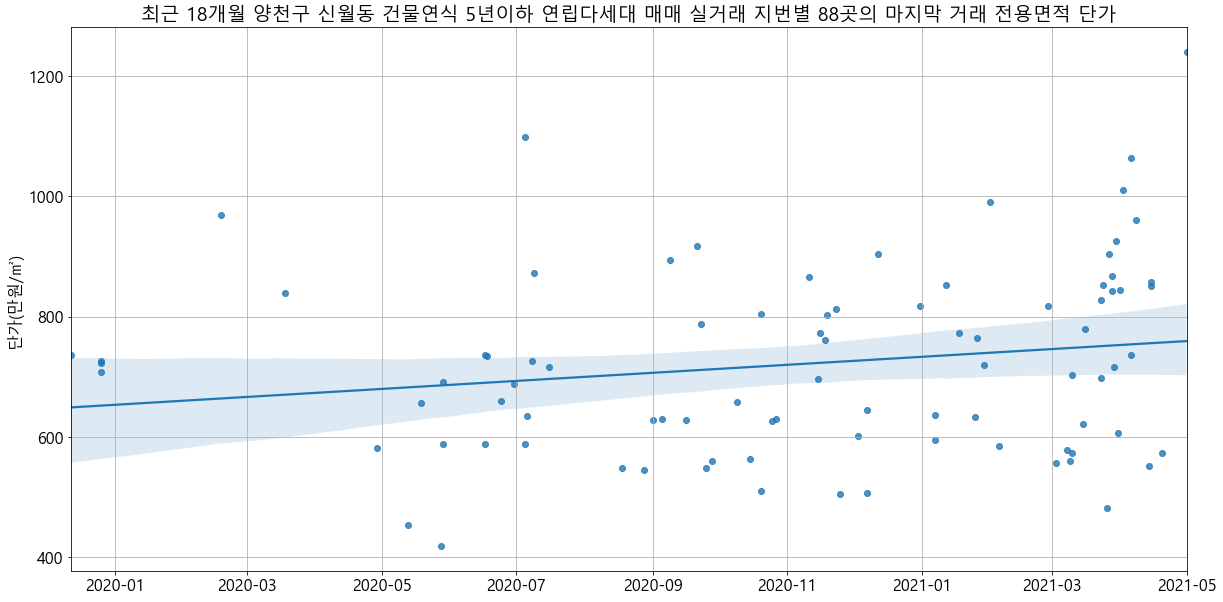

In [21]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 마지막 거래 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(concat_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(concat_last_df['계약날짜']), y=concat_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/지번별_산포도.png'.format(target_gu, target_dong, target_house))

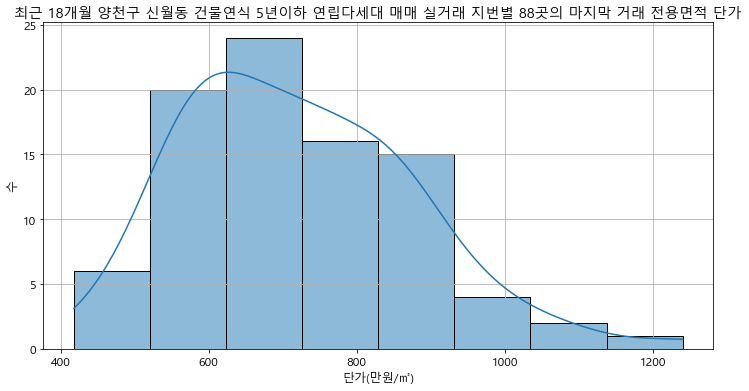

<Figure size 432x288 with 0 Axes>

In [22]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.grid(True)
plt.ylabel('수')
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 마지막 거래 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
sns.histplot(concat_last_df['단가(만원/㎡)'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house))
plt.show()
plt.clf()

In [23]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [24]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '계약날짜', '단가(만원/㎡)', '용도지역명1']]
concat_last_df

,지번주소,건물(단지)명,건축년도,계약날짜,단가(만원/㎡),용도지역명1
0,서울특별시 양천구 신월동 100-22,테마100,2020.0,2020-10-20,804.172275,제2종일반주거지역
1,서울특별시 양천구 신월동 103-5,보노하우스,2020.0,2020-11-19,802.944128,제2종일반주거지역
2,서울특별시 양천구 신월동 104-19,씨티하우스,2019.0,2020-02-18,968.280467,제2종일반주거지역
3,서울특별시 양천구 신월동 1072-0,아레테시티,2016.0,2021-03-26,481.927711,제2종일반주거지역
4,서울특별시 양천구 신월동 108-12,코지빌,2020.0,2021-04-15,857.755540,제2종일반주거지역
5,서울특별시 양천구 신월동 111-1,다인홈타운,2017.0,2021-03-09,559.427387,제2종일반주거지역
6,서울특별시 양천구 신월동 112-10,예담뜰,2019.0,2020-06-30,686.912509,제2종일반주거지역
7,서울특별시 양천구 신월동 112-24,삼성쉐르빌,2017.0,2020-12-07,505.809979,제2종일반주거지역
8,서울특별시 양천구 신월동 126-36,삼화에코빌,2020.0,2020-05-19,655.821567,제2종일반주거지역
9,서울특별시 양천구 신월동 131-8,라온빌,2017.0,2020-06-17,587.248322,제3종일반주거지역


In [25]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house), index=False)